The recent [riddle on FiveThirtyEight](http://fivethirtyeight.com/features/how-many-cars-will-get-stuck-in-traffic/) blog asks
How Many Cars Will Get Stuck In Traffic?

> There is a very long, straight highway with some number of cars (N) placed somewhere along it, randomly. The highway is only one lane, so the cars can’t pass each other. Each car is going in the same direction, and each driver has a distinct positive speed at which she prefers to travel. Each preferred speed is chosen at random. Each driver travels at her preferred speed unless she gets stuck behind a slower car, in which case she remains stuck behind the slower car. On average, how many groups of cars will eventually form? (A group is one or more cars travelling at the same speed.)

I thought of the answer for a bit, and decided to simulate it, to gain some confidence, because nothing clear came to mind. So I deployed a `pymc` model. It is ofcourse an overkill - `pymc` is amazing at fitting stochastic variables to observed data, but in this case there is no data. Yet, `pymc` is a main tool for me these days, and I like to practice with it. Also, it's a really nice simulation framework.

This post can also be found as an Jupyter notebook [Here]()

In [1]:
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight') # Because why not?

### Modeling the Original Problem
I decided on taking a large enough $N = 2^{12}$, that will still compute reasonably fast. I then create `cars` - a list of car variables ("Cariables" I call them, as a big fan of puns) that are uniformly distributed from 0 to 100. The original question does not state the speed, but there is no loss of generality here. finally the parameter `groups` takes the list and computes the number of groups.

Note that there is no observed data so there is no `update` step and the next round, sample the cars from the same uniform distribution.

In [110]:
# Cars
N = 2**12
cars = [pm.Uniform("car_{}".format(x), lower=0, upper=100) for x in range(N)]

# Groups
@pm.deterministic()
def groups(cars=cars):
    current_speed = 101
    answer = 0
    for car in cars:        
        if car < current_speed:           
            answer += 1
            current_speed = car
    return answer

#Create the model

model = pm.Model(cars+[groups])
mcmc = pm.MCMC(model)
mcmc.sample(3000)

 [-----------------100%-----------------] 3000 of 3000 complete in 272.0 sec

To get a sense of the answer, I decided to plot it on a histogram, and of course compute the average which is asked for.

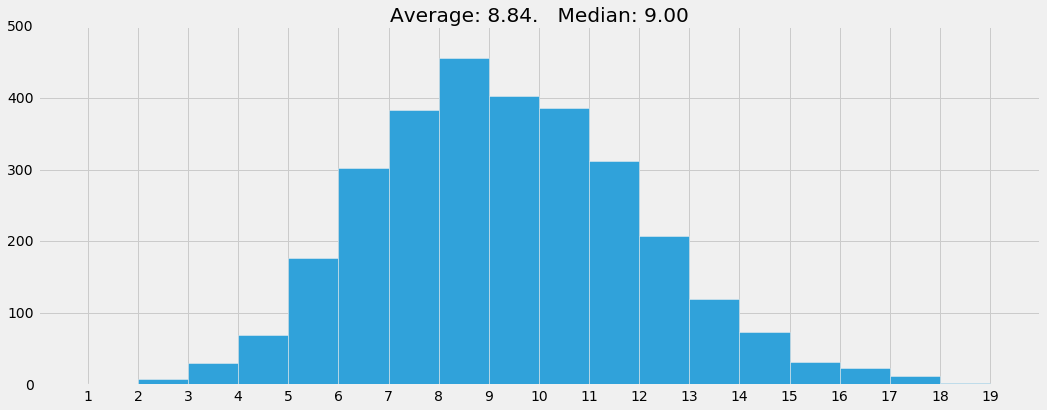

In [111]:
# Trace for how many groups
samples = mcmc.trace('groups')[:]

# Plot the histogram
bins = np.arange(1, 20)
fig, axs = plt.subplots(figsize=(16,6))
axs.hist(samples, bins = bins) # Plot
axs.set_xticks(bins)
axs.set_title("Average: {:.2f}.   Median: {:.2f}".format(samples.mean(), np.median(samples)))
plt.show()

This was very suprising, considering I first thought of something around $\frac{N}{x}$ where $x$ is a small number like 2,4 or 10. But this seems more like a log of something.
I've tried many options, but couldn't find anything smart, so I now I have to really think about it.

## Induction
Let's use the old high-school induction. It never fails. If $E(n)$ is the expectd number for $n$ cars it's trivial that $E(1) = 1$. Now, let's assume we know the answer for $E(n-1)$.
### Qunatities
Let's take $n-1$ and add one in the front. If it's the fastest car, then it drives off to the horizon, while the other cars play the previous $n-1$ game. Unless, it is not the first car. It is still the fastest, so it has two propertis:
* It's faster then the car in front of it, so it must join its group.
* It's faster then the car behind so it doesn't create a new group.

All in all, if the fastest car is not the first car, we can expect $E(n-1)$ groups


### Probablities
Now, what is the chance for a car to be the fastest? That could turn out to be a hard computation on the general case, but pretty easy if the distriution is the same for all cars, and here it is. So from symmetry, the chance of the fastest car to be the first car is exactly $\frac{1}{n}, and $\frac{n-1}{n} to be one of the rest. That results in:
$$E(n) = \frac{1}{n} \cdot (E(n-1)+1) + \frac{n-1}{n} \cdot E(n-1) = E(n-1) + \frac{1}{n}$$
![Out Run](OutRun.png)

## The Answer
We can now recursivly go backwards until 1 and get the final anwer:
$$E(N) = \sum_{i=k}^{N} \frac{1}{k}$$
which is of course the [harmonic number](https://en.wikipedia.org/wiki/Harmonic_number). A nice property of it is that it does not converge, but it diverges very slowly. I'll now want to check my model.

In [215]:
E = lambda n: sum([1./x for x in range(1,n+1)])
print ("Slow divergence: {:.2f}".format(E(10 ** 6)))
print ("Test model: {:.2f}".format(E(N)))


Slow divergence: 14.39
Test model: 8.90


It's bad news, since even if you have a million people before you, you'd still wait in only about 14 groups. And each of them is really slow...  
Also, my model seems close enough to the answer, __so I'm happy__!

# Coolest Riddler Extension Award

Next The Riddler gives extra credit for inventing another question and solve it.
> Spice up this mathematical roadtrip problem for your fellow readers. Alter the road, add a lane, enact some traffic laws, or something far more creative than I can think of. Submit a description and analysis in the form below, or shoot me a link to your work [on Twitter](https://twitter.com/ollie).

So I have a model that I built although it could be solved fast enough when apply a bit of though. I didn't want to waste it so I'm defining a slightly more complex problem.

## The Oncoming Lane Expansion
Now, we have another lane. It's the oncoming lane. You can take this lane to overtake another car, but because other cars are coming from the other direction you have to overtake the fron car __fast enough__. Question is - what is fast enough? I define fast enough by the parameter $F$. if I'm driving car $C_i$ and i'm behind car $C_{i-1}$ then I can over take $C_{i-1}$ If I'm at leat $F$ times as fast as they are: $C_i > F \cdot C_{i-1}$. Then we switch places and we can run over all cars again, until no one can overtake any other person (Let's call it $F-ordered$). A few immediate conclusions:
* $F = \inf$ will result in the original problem.
* $F = 1$ will result in a perfect order, and there will be N groups.
* $F < 1$ on most cases will never reach an order.

### Creating a Model Factory
One of the nicest things I found in the `pymc` docs is the [model factory](https://pymc-devs.github.io/pymc/modelfitting.html#creating-models). I'm create a model factory where I can change $F$. Later I will draw a few of the model posterior distributions and try to understand the behaviour.

In [81]:
def make_model(N=2**2, F = 1):
    # Original Order for cars
    cars = [pm.Uniform("car_{}".format(x), lower=0, upper=100) for x in range(N)]

    # This will deal with the F-ordering
    @pm.deterministic()
    def traffic(cars=cars):
        stop = False
        t=0
        while not stop:
            if t>50: # Avoid inifinite loops
                print "STOP"
                break
            stop = True # Loop will end unless is changed later
            current_speed = 101
            for i in range(len(cars)):
                speed = cars[i]
                if speed < current_speed:
                    current_speed = speed
                if speed > current_speed * F:
                    cars[i], cars[i-1] = cars[i-1], cars[i]
                    #List order changes, but because next car is i+1 we can keep the loop
                    stop = False # If the order change will run through the cars again.
        return cars

    # Groups - Nothing changes except the cars list is the new variable traffic
    @pm.deterministic()
    def groups(cars=traffic):
        current_speed = 101
        answer = 0
        for car in cars:        
            if car < current_speed:           
                answer += 1
                current_speed = car
        return answer
    return locals()

Model creation no for each new $F$ is really easy. I'm creating a list of a few models, run them, and finally plot them one against each other.

In [82]:
# # #Create the model
N = 2**6
Fs = [1,1.001,1.01,1.1,2,101]
models = [make_model(N=N, F=f) for f in Fs]
mcmcs = [pm.MCMC(m) for m in models]
for m in mcmcs:
    m.sample(500, progress_bar=True)


 [-----------------100%-----------------] 500 of 500 complete in 1.7 sec

Plotting all the distributions against each other

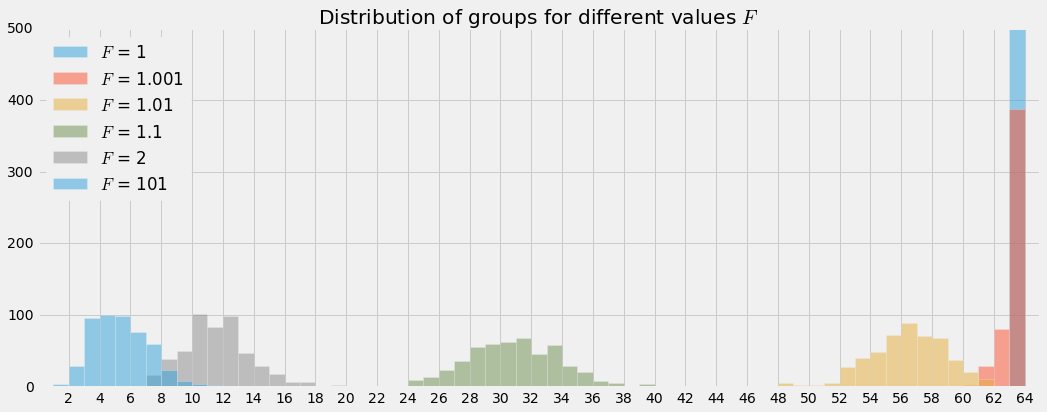

In [86]:
samples = [m.trace('groups')[:] for m in mcmcs]

# Plot the histogram
bins = np.arange(1, N+1)
fig, axs = plt.subplots(figsize=(16,6))
for i, sample in enumerate(samples):
    axs.hist(sample, bins = bins, label="$F$ = {}".format(Fs[i]), alpha = 0.5) # Plot
axs.set_xticks(bins[1::2])
axs.set_xlim([0,N+1])
axs.set_title("Distribution of groups for different values $F$")
axs.legend(loc='best')
plt.show()

Somehow, I had a hunch this will be the case. But I'm not sure I can do a good job of explaining why. See how $F=2$ is really close to $F = 101$ (Which is practically $\inf$ here)? and 1.1 is halfway between 1 and $\inf$? Very interesting.
Last thing I'm interested is the relationship between $F$ and the average number of groups.

In [87]:
# # #Create the model
N = 2**6
Fs = np.hstack([np.arange(1,2.5,0.1),np.arange(2.5,10,1),np.arange(10,100,10),101])
models = [make_model(N=N, F=f) for f in Fs]
mcmcs = [pm.MCMC(m) for m in models]
for m in mcmcs: # I want just the average so I'll sample only 30 times for each model.
    m.sample(30, verbose=0, progress_bar=True)
samples = [m.trace('groups')[:].mean() for m in mcmcs]    

 [-----------------100%-----------------] 30 of 30 complete in 0.1 sec

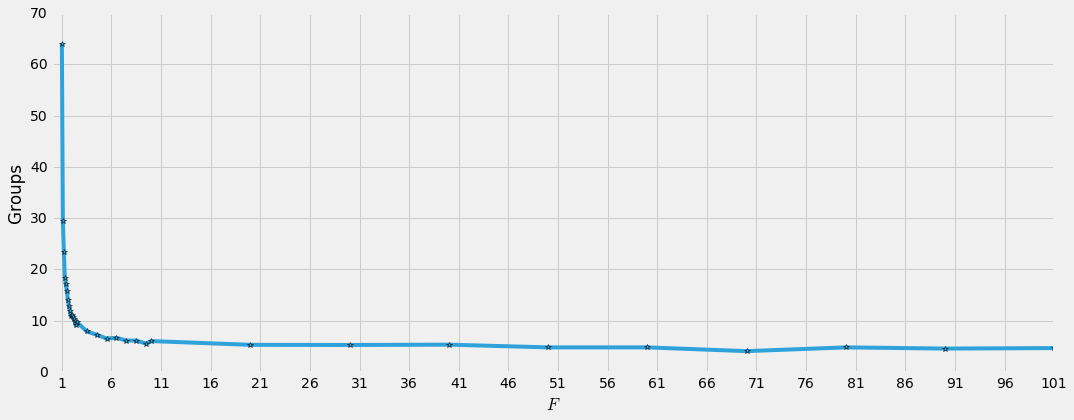

In [111]:
fig, axs = plt.subplots(figsize=(16,6))
axs.plot(Fs, samples, "-*")
axs.set_xticks(np.arange(1,102,5))
axs.set_xlim([0,101])
axs.set_ylabel("Groups")
axs.set_xlabel("$F$")
plt.show()

That's it for today. If anyone can suggest an analytic solution to the Oncoming Land Expansion and $F$-ordering I'd love to hear about.